# Track objects using SiamMask

**Object Tracking** is a methodology that helps to monitor moving objects over a sequence of video frames.

**SiamMask** is used to detect and segment objects from videos in each frame, initializing a single bounding box and outputing segmentation mask and objects boxes. It performs both visual object tracking(VOT) and semi-supervised video object segmentation(VOS). The aim of **VOT** is to estimate its position in all the subsequent frames with the best possible accuracy. Similarly, **VOS** consists of a binary segmentation mask which expresses whether or not a pixel belongs to the target. 


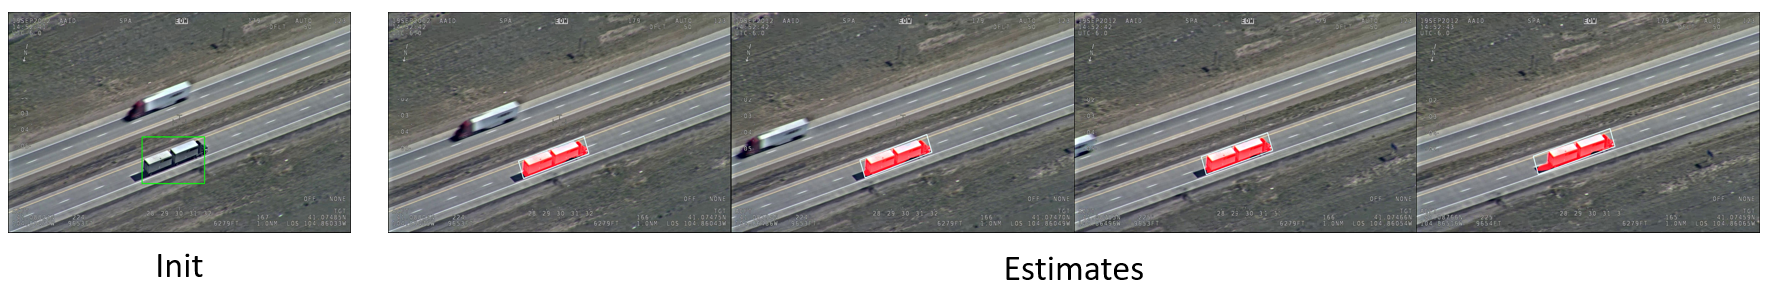

### SiamMask architecture

SiamMask adds a new branch in fully convolutional Siamese network to produce a pixel-wise binary mask. This is achieved
by extending existing Siamese trackers with an extra branch and loss.

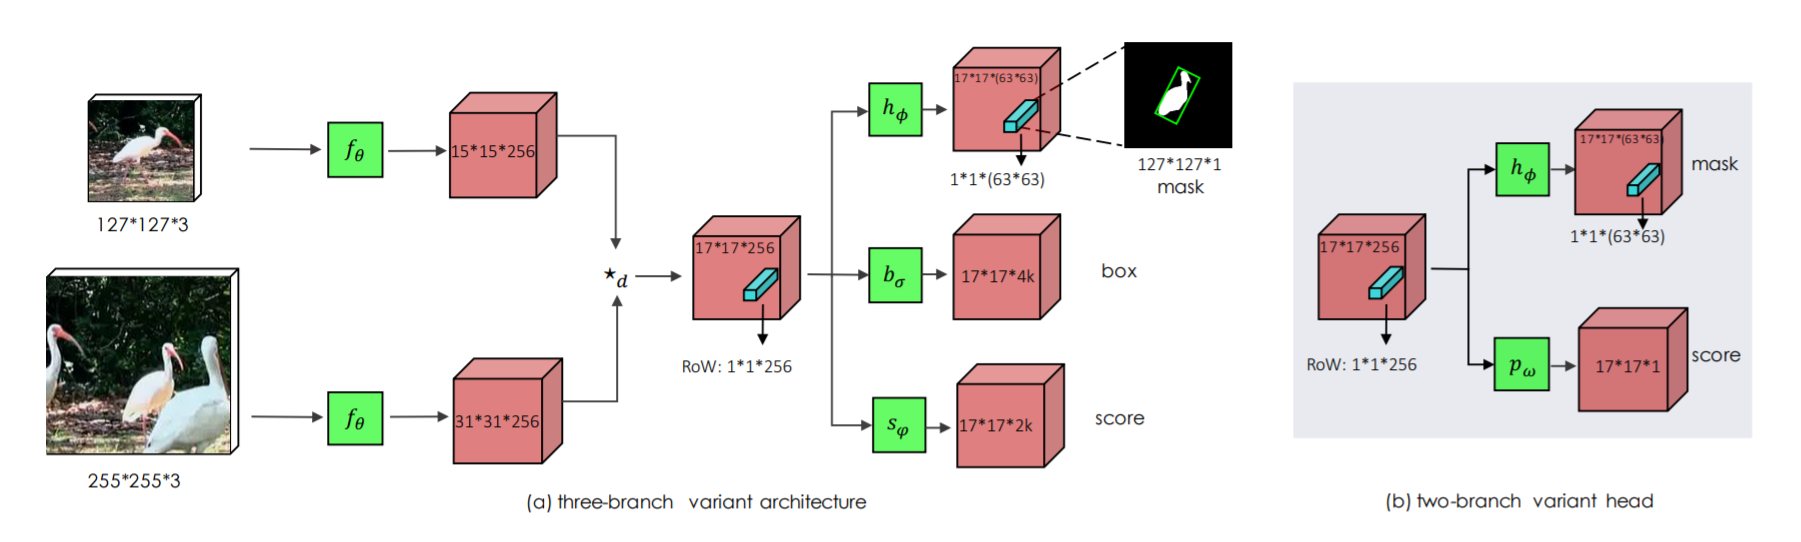

**Backbone** SiamMask uses ResNet-50 as backbone, the architecture remains with the first 4-th stage of ResNet, adding adjust layer and depth-wise cross-correlated resulting a feature map of size 17×17.


**Network heads** The conv5 block in the architecture contains a normalisation layer and ReLU non-linearity while conv6 only consists of a 1×1 convolutional layer

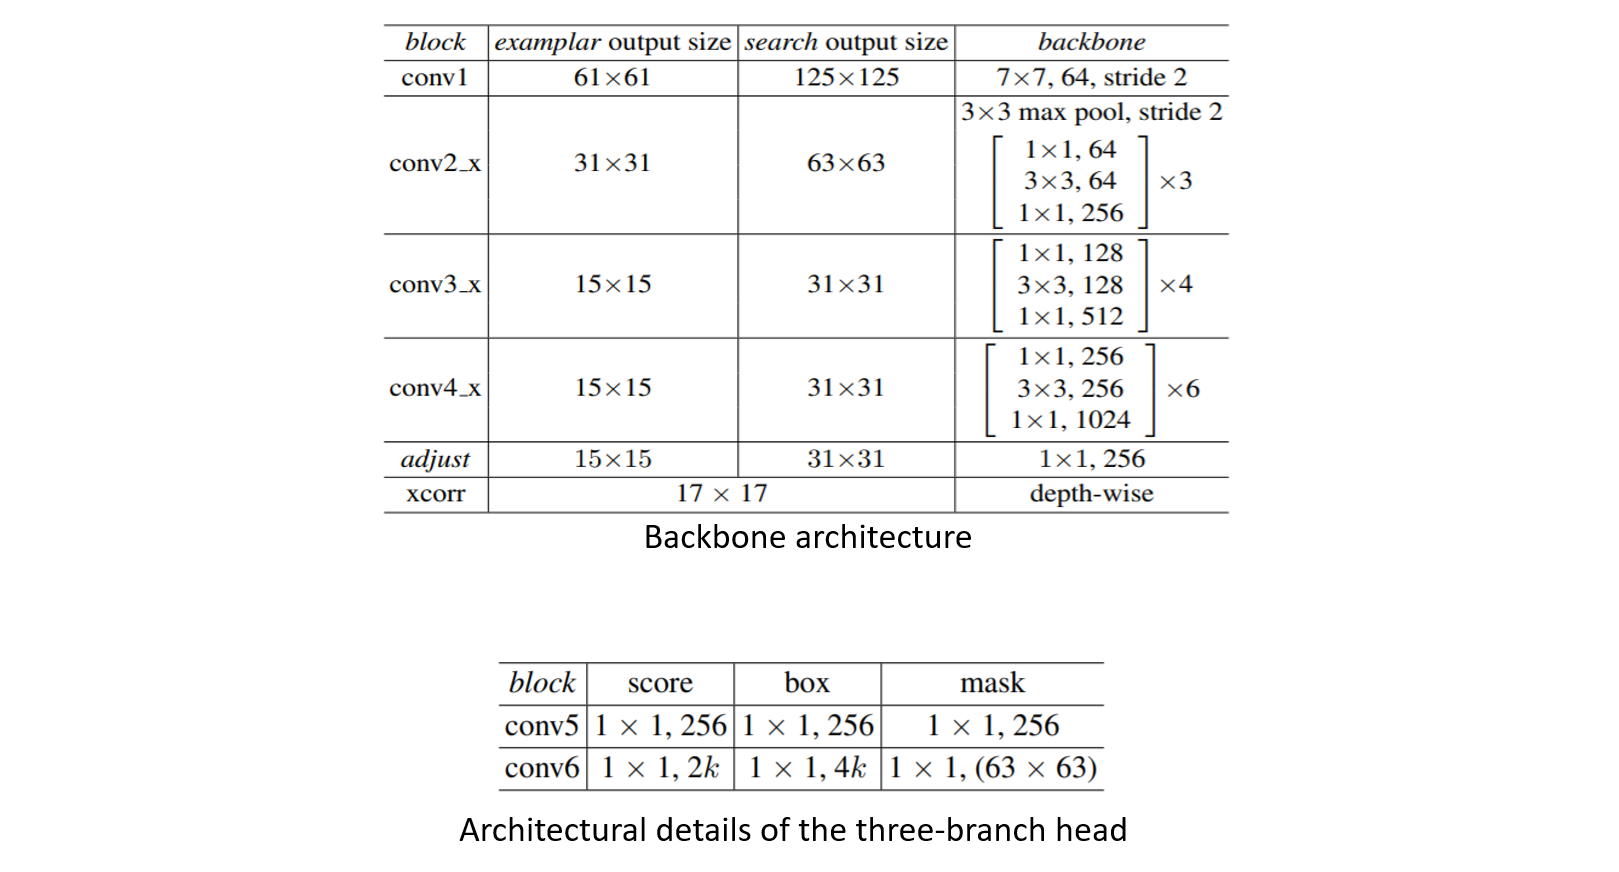


**Refinement** It merges low and high resolution features using multi- ple refinement modules made of upsampling layers and skip connections.

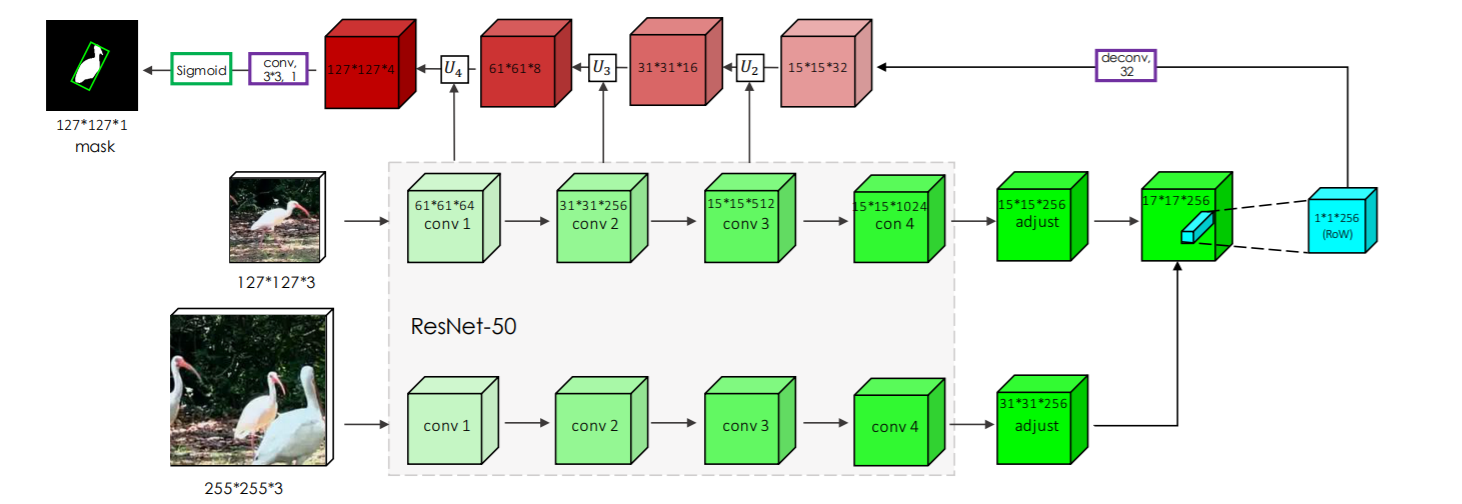



## SiamMask implementation in `arcgis.learn`

Import the SiamMask class from arcgis.learn module.

In [ ]:
from arcgis.learn import SiamMask

### Using DAVIS pretrained weights

To use the model DAVIS pretrained weights, initialize the model as following

ot = SiamMask()

**Note**: the model must be initialized without providing any data. Because we are not training the model and instead using the pre-trained weights, we do not require a databunch. The initialized model can be used to track object **link**

### Train SiamMask model using custom dataset

Prepare databunch for SiamMask model using prepare_data() in arcgis.learn.

When we have data in this specific format, we can call the prepare_data function with dataset_type='ObjectTracking' and for better results use batch_size=64.

In [ ]:
from arcgis.learn import prepare_data
data = prepare_data(r"path_to_data_folder", dataset_type="ObjectTracking", batch_size=64)

Once the data is prepared the SiamMask class can be initialized as follows

ot = SiamMask(data)

### Fine tune an already trained model

In [ ]:
ot.load(r"path_to_emd_file")

## init and update methods

### Initialize the object

This method helps in initializing the object using bounding boxes

In [ ]:
tracks = ot.init(img, [[x,y,w,h]], [["truck"]])

* The parameters to be passed are as follows:
    * `frame`: Required numpy array. Frame from the video on to initialize the object to track.
    
    * `detections`: Required list. A list of bounding boxes to intialize the object. 
                    Eg: [[x, y, w, h]]
                    x, y, w, h represents value of x-cordinate, y-cordinate, width of bbox, height of bbox
                    respectively.
    
    * `labels`: Optional list. A list of labels that represents the class of the object.
    
    * `reset`: Optional Boolean. If set to True all the previous track will get reset. 
    

The method returns list of initialized tracks
    
**Note** The length of detections should match to the length of labels

### Update the location of the object

This method helps in updating the tracks in the next frames

In [ ]:
state = ot.update(frame)

* The parameters to be passed are as follows:
    * `frame`: Required numpy array. Frame from the video to update the track of object location.

The method returns list of updated tracks

### Track object in a video using SiamMask

* Execute the cell below to play the video.
* Press **spacebar** to pause the video.
* Use your mouse to annotate the object in the frame.
* Once annotated, press **spacebar** to track the object.
* press **q** to quit.

**Note** The following code is an example of the usage of SiamMask API. Although API functions can be used in other ways also.

In [ ]:
import numpy as np
import cv2

cap = cv2.VideoCapture(".\object_tracker\DJI_0456.MOV")  ## Read the video file
width = 1000
height = 700
cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
initialized = False
while(True):
    ret, frame = cap.read()
    frame = cv2.resize(frame, (1100, 600)) 
    if initialized:
        state = ot.update(frame)  ## Update the track location in the frame
        for track in state:
            p1 = (int(track.bbox[0]), int(track.bbox[1]))
            p2 = (int(track.bbox[0] + track.bbox[2]), int(track.bbox[1] + track.bbox[3]))
            mask = track.mask
            frame[:, :, 2] = (mask > 0) * 255 + (mask == 0) * frame[:, :, 2] ## Display predicted mask
            cv2.polylines(frame, [np.int0(track.location).reshape((-1, 1, 2))], True, (w, 255, h), 1) ## Display predicted rectangle
            
    cv2.imshow('frame',frame)
    key = cv2.waitKey(1)
    if key & 0xFF == ord('q'):
        break
    
    if key == 32:
        init_rect = cv2.selectROI('frame', frame, False, False)
        values = np.array(init_rect)
        if all(values == 0):
            continue
        x, y, w, h = init_rect
        state = ot.init(frame, [[x,y,w,h]]) ## Initialize the track in the frame
        initialized = True
        cv2.waitKey()

cap.release()
cv2.destroyAllWindows()

## References

Fast Online Object Tracking and Segmentation: A Unifying Approach; [https://arxiv.org/abs/1812.05050]

SiamMask [https://github.com/foolwood/SiamMask]